This file is to go through the basic process of Bayesian optimisation

Background:

Take one measurement is very time-consuming and/or expensive.
The measurement is associated with noise.

We want to find the potential optimal of the studied system with as few experimental data as possible.
We assume there is no prior knowledge of this model.

That's saying, we want to optimise a blackbox problem with limited amount of data.

In [53]:
#Step 1: Generate data according to assumed model
#y = 0.5*x**2+0.3*x+0.1
#add a Gaussian random perturbation of with maximum scale as 1

#Note that this parabola model below is beyond our prior knowledge, and is just an example that works best with my brain.
#Let's say it's defined by some magic force (but we have to create it to explain this process.)

#In real case, we only have a group of data, which is the real_X, real_Y below,
#but we would not know the relationship between them, i.e., the equation in std_model function, we don't know that.

In [1]:
import numpy as np
seed = 95
np.random.seed(seed)

In [2]:
import matplotlib.pyplot as plt

In [3]:
def std_model(X:np.ndarray)->np.ndarray:
    """
    This is the standard model without noise
    """
    Y = 0.5*X**2 + 0.3*X + 0.1 #This is a pre-defined real physical model
    return Y

def exp_model(X:np.ndarray, noise_level = 1):
    #noise_level is the standard deviation, 67% of the data will be within pm 1 from the centre y data
    Y = std_model(X)
    noise = np.random.normal(scale = noise_level, size = Y.shape)
    real_Y = Y + noise
    return real_Y
    

In [4]:
#generate the initial X
X = np.linspace(-10, 10, 201) #Generate 201 initial points from -10 to 10
Y = std_model(X)
real_X = np.random.uniform(-10, 10, 11) # this is the perturbated series.
real_Y = exp_model(real_X)

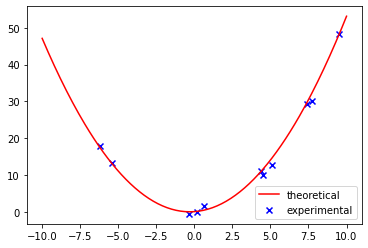

In [5]:
fig, ax = plt.subplots()
ax.plot(X, Y, color = 'red', label = 'theoretical')
ax.scatter(real_X, real_Y, color = 'blue', marker = 'x', label = 'experimental')
ax.legend()

In [6]:
#Perfecto!
#Now we have our 11 measurements (labelled as cross)
#Ignore the red line behind it for now. We will come back to that later.

In [7]:
#Step 2: Now let's welcome Thomas Bayes, the father of Bayesian statistics
#https://en.wikipedia.org/wiki/Bayesian_statistics

#Step 2.1: Gaussian process regression
#https://scikit-learn.org/stable/modules/gaussian_process.html
# Gaussian Processes (GP) are a nonparametric supervised learning method
#used to solve regression and probabilistic classification problems.

#If we need Bayesian optimisation, we have numerical data that are waiting to fit.
#That means we are doing a regression process.
#GPR: Gaussian Process Regression
#https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor

In [8]:
from sklearn.gaussian_process import GaussianProcessRegressor as GPR

In [9]:
#We need to first specify the "kernel"
#https://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes

#Which kernel to use?
#The answer depends on our expectation on the property of our model.
#For example, if we think the model is oscillating, then our kernel should idelly include some oscillating properties,
#such as sigmoid functions.
#If the model is expected to be smooth, then we can use radial basis function (RBF).
#The key property of RBF is that different features would have similar contribution towards the correlation with our observables.
#If we have a specific feature that might have a super strong correlation, then RBF may not be suitable.

In [10]:
#What is a kernel?
#Kernel describes the covariance between X's of the measurement.

#Suppose you have two series of measurement [X1, Y1], [X2, Y2].
#You input (X1, X2) to the kernel function, and you will get a covariance between Y1 and Y2.


So what is the feature of different types of kernels?

#Basic kernels:

1) constant kernel: the covariance among measurements is a constant. (No matter how far your two data points are apart on the x-axis, their y values always have a same covariance.) This kernel modifies the mean of the Gaussian process.

2) white kernel: There is no correlation between any sample points. However, each sample point has an intrinsic noise.

The above two are useful for kernel operations

Radial basis function kernel (RBF): The closer two measurements are, the higher correlation they have.

The correlation decays by expoential way in RBF, but can be modified in other kernels, for example, Matern, rational quadratic,
that helps with the modification on curve smoothness too.

Exp-Sine-Squared kernel: this includes the periodicity feature in the decay.

Dot-product kernel: this is a not-guarantee-to-converge kernel, and is non-stationary. It is invariant to rotation but not translation. 

In [15]:
#In this case, we first try RBF plus a white noise
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
# kernel = WhiteKernel(0.05) + RBF(0.01) #this is a sum kernel from WhiteKernel with RBF, this doesn't work for my system.
kernel = 1*RBF(length_scale = 1, length_scale_bounds = (1e-2, 1e2)) + 0
#Here is the tricky part, the length_scale, even remain same, could leads to different results

#I tried 1 as the length_scale before, doesn't give a sensible results, everything is close to 0 after prediction
#so I get rid of the whitekernel, the noise is added to gpr alpha parameter.

#alpha is the variance of the gaussian noise
#the 1 multiplied at the beginning is to add one more parameter (the coefficient here) to the model.
#GPR will automatically modify those new parameters, for example we can also add a constant, 0, at the end.
#C.f. the result printed after next cell, see how the coefficient has changed.

In [16]:
#Now we will feed our "experimental data", real_X and real_Y into the fitting model. 
#Note that if the data is one-dimensional, sklearn requires to reshape the x data into (-1, 1)
gpr = GPR(kernel = kernel, alpha = 1, random_state = 1).fit(real_X.reshape(-1, 1), real_Y)
#Note that you are not expected to see any warning message, otherwise you need to modify hyperparameters or remove the random_state argument.
#Do not ignore Warnings before carrying out predictions.
#The warning message can tell you convergence failed or not.

print("kernel after training: \n")
print(gpr.kernel_) #tell you what is the kernel hyperparameters

print("score: \n")
print(gpr.score(real_X.reshape(-1, 1), real_Y)) #compare the predicted y calculated from real_x with real_y

kernel after training: 

162**2 * RBF(length_scale=19.1) + 0.00319**2
score: 

0.9960874767807


C:\Users\sh19129\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))


In [ ]:
#Note that the coefficients have been automatically modified above

In [17]:
#predict y
#We use the original 201 x's from the fitting curve, again, we don't know it's the fitting result before this prediction..
#See what y's can we have from the gpr results
#the Predict function return y_mean, y_std and y_cov. The latter two need to be specified as True when calling the function.
#https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor.predict
y_mean, y_std = gpr.predict(X.reshape(-1, 1), return_std = True)

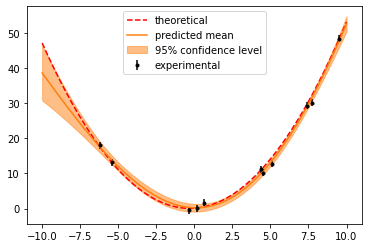

In [18]:
fig, ax = plt.subplots()
ax.plot(X, Y, color = 'red', ls = '--', label = 'theoretical')
ax.errorbar(real_X, real_Y, yerr = 1, color = 'black', ls = 'None', marker = '.', label = 'experimental')
#yerr is the noise_level used above
ax.plot(X, y_mean, color = 'tab:orange', label = 'predicted mean')
ax.fill_between(X, y_mean-y_std*1.96, y_mean+y_std*1.96, alpha = 0.5, color = 'tab:orange', label = '95% confidence level')
#1.96 on std is to plot 95% confidence interval
#This step is the one to give you the transparent fillings behind the curve.
#Also the iconic styles seen in BO related papers.
#However, if you try to run the workflow again, this confidence interval part could change.
#There are many random factors involved there...
ax.legend()

In [19]:
#Gaussian process has completed by this step

In [20]:
#Step 2.2: acquisition function
#This is the thing that BO is optimising
#Aquisition function tells us which point to go next.
#The point you follow this function is more likely to give you a better result

#Four common acquisition functions:
#https://www.cse.wustl.edu/~garnett/cse515t/spring_2015/files/lecture_notes/12.pdf

#Probability of improvement (POI), Expected improvement (EI), Entropy search (ES), Upper confidence bound (UCB),
#among which UCB is normally used for finding the maximum, and is the most straightfoward method to implement, but not guaranteed to be the best

In [21]:
#UCB is similar to the concept of confidence level, but with a coefficient, beta, before std
#see what we've done above, beta is 1.96 for 0.95 CI

#ES: a method without a clear expression. You need to define what is the entropy first. It's hard to do with current technique.

#EI: The point with the highest expected improvement (the maximal expected f_next) is selected according to the result of GP,
#which gives the probability distribution of any point on the curve.

#POI: similar to EI, but the foundation is probability instead of expectation. 

In [22]:
#let's go for UCB for simplicity.
#There are packages available, but for fun, and to understand this process better, we write the optimisation by ourselves. 

In [23]:
from scipy.optimize import minimize

In [24]:
def aq_func_ucb(x, beta, gpr):
    """
    Although it is called ucb, the form it takes in this function is to minimise the acquisition function
    """
    mean, std = gpr.predict(x.reshape(-1,1), return_std = True)
    return mean - beta*std

In [25]:
x0 = -0.1 # the initial guess of the model, or the starting point, can be an average of all the previous data

res = minimize(aq_func_ucb, x0 = x0, args = (1.96, gpr), tol = 1e-4) #this is one step of BO

#the result says where shall we go next step
#note that the tol argument can affect the convergence successful or not
#print(res)

#important features: success and x
print(f"success?: {res.success}")
print(f"x: {res.x}") #next x

success?: True
x: [-0.0243555]


In [ ]:
#The result in the cell above could be sensitive towards the setting of x0
#I assume in the complicated cases, where you have local and global minimals, the selection of x0 need to be tried many times.

#The second result:x, is the point that BO suggests you to try next in your measurement.
#Note that this is only valid when "success?" is True.
#So in practice, you can choose to trust the predicted next x and carry out your next (expensive) measurement.
#The next x, by statistics, is expected to be the most optimal choice based on your previous measurements.
#If the result of next x indeed gives you a more optimial solution, that's great!
#Else, no problem, you still learnt something new, but maybe because the data is not sufficient to figure out the true trend,
#just add the new measurements to the X_real, Y_real set you started with, 
#And we can refine the model!

In [322]:
#the next steps are 1) to add this "next x" to the training set.
#2) repeat the gpr to get a new gpr.
#3) repeat the ucb to get the next x. Note that x0 would need to be the previous x, but can also be any guessed x.
#It's all depends on what you want to do..
#i.e., the goal of why you use BO.

#For example, if you want to find a local minimal, you've already done this.
#But if you want to explore more area in the vast data space, you can try a far away x0 to look for, maybe, a global minimal.
#Just to cover more groud.
#Bear in mind that the real-life data distribution is not necessary to be as simple as a parabola as we showed here.

In [323]:
#To make this method more useful, we need further abstraction... This is just an initial step.

#Check here for the envelopped class: https://github.com/xueannafang/learn_opt/blob/main/Bayes_opt_class.ipynb